# 🌊 Flood Loss Analysis - Test Notebook

This notebook tests the **UNSAFE-integrated flood loss module** and demonstrates the complete TerraAgent workflow.

**Key Features:**
- Integration with [UNSAFE](https://github.com/abpoll/unsafe) framework
- HAZUS depth-damage functions
- First Floor Elevation (FFE) uncertainty
- Monte Carlo loss estimation

In [1]:
# Setup - Add parent directory to path
import sys
sys.path.insert(0, '..')

## 1. Check UNSAFE Installation Status

In [2]:
from src.science_flood import check_unsafe_installation, get_flood_locations

# Check installation status
status = check_unsafe_installation()
print("🔍 UNSAFE Installation Status:")
print(f"  ├─ Package Installed: {'✅' if status['installed'] else '❌'} {status['installed']}")
print(f"  ├─ Data Ready: {'✅' if status['data_ready'] else '❌'} {status['data_ready']}")
print(f"  ├─ Mode: {status['mode']}")
print(f"  └─ Data Dir: {status['data_dir']}")

if not status['installed']:
    print(f"\n⚠️ To install UNSAFE: {status['install_command']}")

🔍 UNSAFE Installation Status:
  ├─ Package Installed: ✅ True
  ├─ Data Ready: ✅ True
  ├─ Mode: direct
  └─ Data Dir: c:\Users\HChen8\OneDrive - University of Iowa\Documents\GitHub\TerraAgent\notebooks\..\data\unsafe


## 2. Available Flood-Prone Locations

In [3]:
from src.science_flood import FLOOD_LOCATIONS

print("📍 Available Flood-Prone Locations:")
print("="*60)
for loc, info in FLOOD_LOCATIONS.items():
    print(f"  • {loc}: ({info['lat']:.4f}, {info['lon']:.4f})")

📍 Available Flood-Prone Locations:
  • Houston, TX: (29.7604, -95.3698)
  • Miami, FL: (25.7617, -80.1918)
  • New Orleans, LA: (29.9511, -90.0715)
  • Cedar Rapids, IA: (41.9779, -91.6656)
  • Sacramento, CA: (38.5816, -121.4944)
  • Charleston, SC: (32.7765, -79.9311)
  • Norfolk, VA: (36.8508, -76.2859)
  • Philadelphia, PA: (39.9526, -75.1652)


## 3. Basic Flood Loss Calculation

In [4]:
from src.science_flood import calculate_flood_loss

# Calculate flood loss for Houston at 1.5m depth
result = calculate_flood_loss(
    location_name="Houston, TX",
    flood_depth=1.5,  # meters
    num_simulations=2000,
    property_value=300000,
    foundation_type="S",  # Slab
    num_stories=1
)

print("🌊 Flood Loss Calculation Result:")
print("="*60)
print(f"  📍 Location: {result['location']}")
print(f"  🌊 Flood Depth: {result['flood_depth_m']:.2f} m ({result['flood_depth_ft']:.2f} ft)")
print(f"  🏠 Property Value: ${result['property_value']:,.0f}")
print(f"  🏗️ Foundation: {result['foundation_type']} ({result['num_stories']} story)")
print(f"  💰 Mean Loss: ${result['mean_loss']:,.0f}")
print(f"  📊 Std Dev: ${result['std_loss']:,.0f}")
print(f"  📈 95% CI: ${result['ci_lower']:,.0f} - ${result['ci_upper']:,.0f}")
print(f"  📉 Damage Ratio: {result['damage_ratio']:.1%}")
print(f"  ⚙️ Using UNSAFE: {'✅' if result['using_unsafe'] else '❌'}")

🌊 Flood Loss Calculation Result:
  📍 Location: Houston, TX
  🌊 Flood Depth: 1.50 m (4.92 ft)
  🏠 Property Value: $300,000
  🏗️ Foundation: S (1 story)
  💰 Mean Loss: $145,625
  📊 Std Dev: $26,093
  📈 95% CI: $102,626 - $191,882
  📉 Damage Ratio: 48.5%
  ⚙️ Using UNSAFE: ✅


## 4. Depth Sensitivity Analysis

In [5]:
print("🌊 Flood Loss - Depth Sensitivity Analysis")
print("="*70)
print(f"Location: Houston, TX | Property: $300,000 | Foundation: Slab\n")
print(f"{'Depth (m)':<10} {'Depth (ft)':<10} {'Mean Loss':>12} {'Damage %':>10} {'95% CI':>22}")
print("-"*70)

for depth_m in [0.1, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0]:
    result = calculate_flood_loss(
        location_name="Houston, TX",
        flood_depth=depth_m,
        num_simulations=2000,
        property_value=300000,
        foundation_type="S",
        num_stories=1
    )
    ci = f"${result['ci_lower']:,.0f}-${result['ci_upper']:,.0f}"
    print(f"{depth_m:<10.2f} {result['flood_depth_ft']:<10.1f} ${result['mean_loss']:>10,.0f}   {result['damage_ratio']:>8.1%}   {ci:>22}")

🌊 Flood Loss - Depth Sensitivity Analysis
Location: Houston, TX | Property: $300,000 | Foundation: Slab

Depth (m)  Depth (ft)    Mean Loss   Damage %                 95% CI
----------------------------------------------------------------------
0.10       0.3        $    28,792       9.6%           $9,910-$50,528
0.30       1.0        $    48,841      16.3%          $25,532-$74,651
0.50       1.6        $    68,157      22.7%          $41,596-$97,082
0.75       2.5        $    90,156      30.1%         $59,303-$124,519
1.00       3.3        $   110,563      36.9%         $76,244-$148,589
1.50       4.9        $   145,014      48.3%        $102,270-$191,017
2.00       6.6        $   174,262      58.1%        $124,086-$227,503
2.50       8.2        $   196,041      65.3%        $139,691-$253,945
3.00       9.8        $   214,993      71.7%        $153,311-$275,017


## 5. Foundation Type Comparison

In [6]:
print("🏠 Foundation Type Comparison (at 1.5m flood depth)")
print("="*70)
print("FFE Distributions (First Floor Elevation):")
print("  • Slab (S):       [0, 0.5, 1.5] ft triangular")
print("  • Crawlspace (C): [0, 1.5, 4.0] ft triangular") 
print("  • Basement (B):   [0, 1.5, 4.0] ft triangular")
print("-"*70)

for ftype, fname in [("S", "Slab"), ("C", "Crawlspace"), ("B", "Basement")]:
    result = calculate_flood_loss(
        location_name="Houston, TX",
        flood_depth=1.5,
        num_simulations=2000,
        property_value=300000,
        foundation_type=ftype,
        num_stories=1
    )
    print(f"  {fname:<12}: ${result['mean_loss']:>10,.0f} ({result['damage_ratio']:.1%}) | 95% CI: ${result['ci_lower']:,.0f}-${result['ci_upper']:,.0f}")

print("\n💡 Higher FFE reduces damage as water must rise higher to reach the first floor.")

🏠 Foundation Type Comparison (at 1.5m flood depth)
FFE Distributions (First Floor Elevation):
  • Slab (S):       [0, 0.5, 1.5] ft triangular
  • Crawlspace (C): [0, 1.5, 4.0] ft triangular
  • Basement (B):   [0, 1.5, 4.0] ft triangular
----------------------------------------------------------------------
  Slab        : $   145,441 (48.5%) | 95% CI: $103,008-$191,249
  Crawlspace  : $   120,861 (40.3%) | 95% CI: $70,277-$174,704
  Basement    : $    61,425 (20.5%) | 95% CI: $42,983-$80,013

💡 Higher FFE reduces damage as water must rise higher to reach the first floor.


## 6. Loss Distribution Visualization

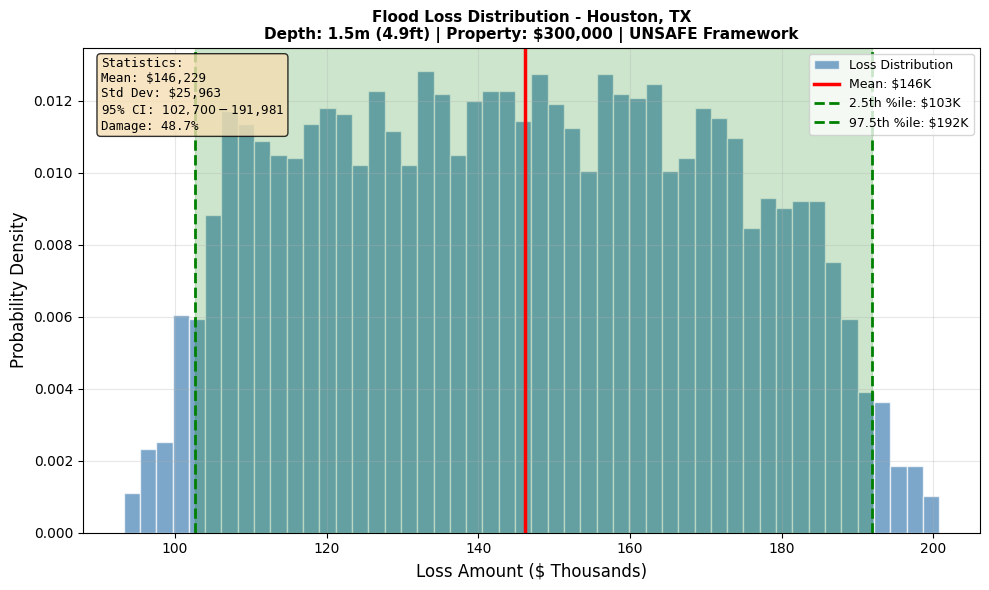

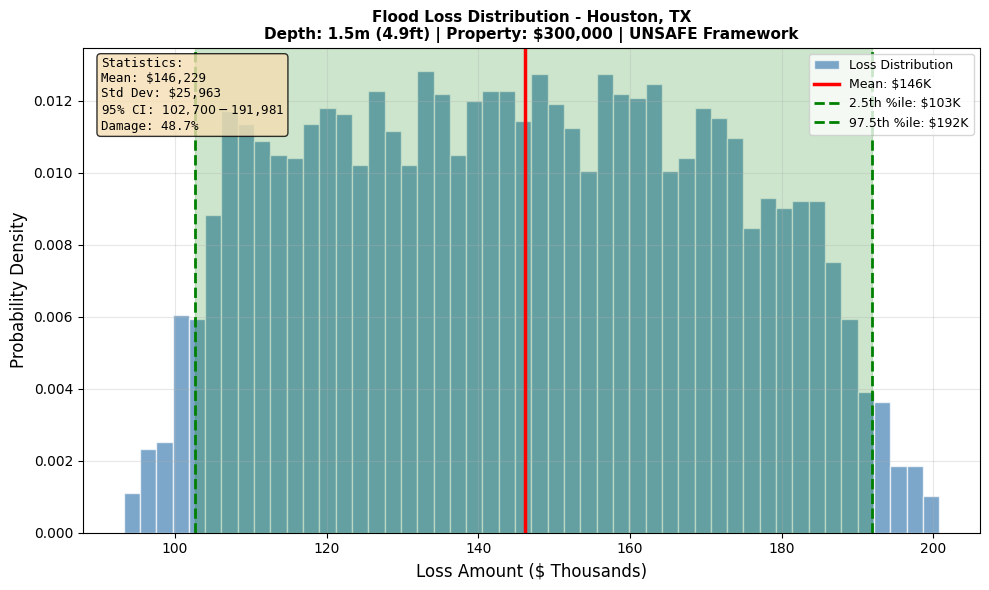

In [7]:
from src.science_flood import create_loss_histogram

# Calculate loss with more simulations for better histogram
result = calculate_flood_loss(
    location_name="Houston, TX",
    flood_depth=1.5,
    num_simulations=5000,
    property_value=300000,
    foundation_type="S",
    num_stories=1
)

# Create and display histogram
fig = create_loss_histogram(result)
fig

## 7. Test Agent Builder (UI Generation)

In [8]:
from src.agent_builder import StreamlitBuilder
import inspect
from src import science_flood

# Create builder (rule-based, no LLM needed)
builder = StreamlitBuilder()

# Get source code of the module
source_code = inspect.getsource(science_flood)

# Analyze the code
analysis = builder.analyze_code(source_code)
print("📊 Code Analysis Result:")
print(f"  • Function Name: {analysis['name']}")
print(f"  • Return Type: {analysis['return_type']}")
print(f"  • Parameters:")
for p in analysis['parameters']:
    print(f"      - {p['name']}: {p['type']} = {p['default']}")

📊 Code Analysis Result:
  • Function Name: calculate_flood_loss
  • Return Type: Dict[str, Any]
  • Parameters:
      - location_name: str = None
      - flood_depth: float = None
      - num_simulations: int = 1000
      - property_value: Optional[float] = None
      - foundation_type: str = S
      - num_stories: int = 1
      - use_unsafe: bool = True


In [9]:
# Generate Streamlit UI code
ui_code = builder.generate_ui_code(source_code, "Create a flood loss estimation app")

print("🎨 Generated Streamlit Code Preview:")
print("="*60)
print(ui_code[:1500])
print("..." if len(ui_code) > 1500 else "")
print("="*60)
print(f"\n✅ Total length: {len(ui_code)} characters")

🎨 Generated Streamlit Code Preview:
"""
Auto-generated Streamlit UI for calculate_flood_loss
"""

import streamlit as st
import matplotlib.pyplot as plt

# Import the science function (paste the function code here or import from module)
# from science_module import calculate_flood_loss

# === PASTE YOUR SCIENCE FUNCTION HERE ===
"""
Flood Loss Uncertainty Assessment Module

This module provides a TerraAgent wrapper for the UNSAFE framework.
UNSAFE (UNcertain Structure And Fragility Ensemble) is an open-source 
framework for estimating property-level flood risk with uncertainty.

Installation:
    pip install git+https://github.com/abpoll/unsafe

Reference: 
    UNSAFE Framework - https://github.com/abpoll/unsafe
    Pollack, A., Doss-Gollin, J., Srikrishnan, V., & Keller, K. (2024)
    DOI: https://doi.org/10.21105/joss.07527

Keywords: Uncertainty Quantification, Probabilistic Modeling, Depth-Damage Functions
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
import ast

# Validate the generated code
try:
    tree = ast.parse(ui_code)
    print("✅ Generated code is syntactically valid Python!")
    print(f"   Contains {len(tree.body)} top-level statements")
    
    # Save the generated app
    app_path = "../generated_flood_app.py"
    with open(app_path, 'w', encoding='utf-8') as f:
        f.write(ui_code)
    print(f"\n📁 Saved generated app to: {app_path}")
    
except SyntaxError as e:
    print(f"❌ Syntax Error: Line {e.lineno}: {e.msg}")

✅ Generated code is syntactically valid Python!
   Contains 49 top-level statements

📁 Saved generated app to: ../generated_flood_app.py


## 8. Generate Launcher Scripts

In [11]:
# Generate launcher scripts for easy app startup
import os

domain = "flood"
app_name = "generated_flood_app.py"

# Windows batch script
bat_content = f'''@echo off
REM TerraAgent - {domain.title()} Analysis Launcher
REM Double-click this file to start the application

echo ============================================
echo   TerraAgent - {domain.title()} Analysis Tool
echo ============================================
echo.

if exist ".venv\\Scripts\\activate.bat" (
    echo Activating virtual environment...
    call .venv\\Scripts\\activate.bat
) else if exist "venv\\Scripts\\activate.bat" (
    echo Activating virtual environment...
    call venv\\Scripts\\activate.bat
)

echo Starting {domain.title()} Analysis Interface...
echo Press Ctrl+C to stop the server.
echo.

streamlit run {app_name}
pause
'''

# Unix shell script
sh_content = f'''#!/bin/bash
# TerraAgent - {domain.title()} Analysis Launcher

echo "============================================"
echo "  TerraAgent - {domain.title()} Analysis Tool"
echo "============================================"

if [ -f ".venv/bin/activate" ]; then
    source .venv/bin/activate
elif [ -f "venv/bin/activate" ]; then
    source venv/bin/activate
fi

echo "Starting {domain.title()} Analysis Interface..."
streamlit run {app_name}
'''

# Save launcher files
bat_path = f"../launch_{domain}.bat"
sh_path = f"../launch_{domain}.sh"

with open(bat_path, 'w', encoding='utf-8') as f:
    f.write(bat_content)
print(f"✅ Created Windows launcher: {bat_path}")

with open(sh_path, 'w', encoding='utf-8') as f:
    f.write(sh_content)
print(f"✅ Created Unix launcher: {sh_path}")

print(f"\n🚀 Double-click launch_{domain}.bat to start the app!")

✅ Created Windows launcher: ../launch_flood.bat
✅ Created Unix launcher: ../launch_flood.sh

🚀 Double-click launch_flood.bat to start the app!


## ✅ Summary

This notebook demonstrates the complete TerraAgent flood analysis workflow:

1. **UNSAFE Integration** - Verified package and data availability
2. **Loss Calculation** - Monte Carlo with FFE uncertainty
3. **Depth Sensitivity** - Damage increases with flood depth
4. **Foundation Comparison** - Higher FFE reduces damage
5. **Visualization** - Loss distribution histogram
6. **Agent Builder** - Generates valid Streamlit UI
7. **IntegratorAgent** - Orchestrates full workflow

**To run the generated app:**
```bash
streamlit run generated_flood_app.py
```
Or double-click `launch_flood.bat` (Windows) / `launch_flood.sh` (Unix)